# Twitter API with Python

In [3]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
from textblob import TextBlob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import credential

In [4]:
# TWITTER CLIENT #
class TwitterClient():
    def __init__(self,twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth) #Twitter API wrapper
        self.twitter_user = twitter_user

    # Extract the data from tweets we get
    def get_twitter_client_api(self):
        return self.twitter_client

    # Returns the 20 most recent statuses posted from the authenticating user or the user specified.
    def get_user_timeline_tweets(self,num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self,num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    # Returns the 20 most recent statuses posted by the authenticating user and that user’s friends.
    def get_home_timeline_tweets(self,num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

# TWITTER AUTHENTICATER #
class TwitterAuthenticator():
    def authenticate_twitter_app(self):
        auth = OAuthHandler(credential.CONSUMER_KEY, credential.CONSUMER_SECRET)
        auth.set_access_token(credential.ACCESS_TOKEN,credential.ACCESS_TOKEN_SECRET)
        return auth

# TWITTER STREAMER #
# Class for streaming and processing live tweets
class TwitterStreamer():
    def __init__(self):
        self.twitter_authenticator = TwitterAuthenticator()

    # Method for handling twitter authentification and the connection to twitter streaming API
    def stream_tweets(self,fetched_tweets_filename,hash_tag_list):
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_authenticator.authenticate_twitter_app()
        stream = Stream(auth,listener)

        # filter twitter streams to capture data by the keywords
        stream.filter(track=hash_tag_list)

# TWITTER STREAM LISTENER #
# Basic listener that prints recived tweets to file
class TwitterListener(StreamListener):
    def __init__(self,fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

# Write the data on a file
    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename,'a')as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" %str(e))
            return True

    def on_error(self, status):
        # Returning False on_data method in case rate limit occurs
        if status == 420:
            return False
        print(status)

class TweetAnalyzer():
    # Function for analyzing and categorizing content from tweets.

    # Clean the tweet and remove any hyperlinks or extra charachters
    def clean_tweet(self,tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    # Tell whether the tweet is positive or negative
    def analyze_sentiment(self,tweet):
        analysis = TextBlob(self.clean_tweet(tweet))

        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1


    def tweets_to_data_frame(self,tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets],columns=['tweets'])

        df['id']=np.array([tweet.id for tweet in tweets])
        df['len']=np.array([len(tweet.text) for tweet in tweets])
        df['date']=np.array([tweet.created_at for tweet in tweets])
        df['source']=np.array([tweet.source for tweet in tweets])
        df['likes']=np.array([tweet.favorite_count for tweet in tweets])
        df['retweets']=np.array([tweet.retweet_count for tweet in tweets])

        return df

In [ ]:
# # Streaming tweets # #
hash_tag_list=["donal trump","hillary clinton","barack obama","bernie sanders"]
fetched_tweets_filename="tweets.txt"

twitter_streamer = TwitterStreamer()
twitter_streamer.stream_tweets(fetched_tweets_filename,hash_tag_list);


{"created_at":"Sun Aug 04 21:30:20 +0000 2019","id":1158128056302821383,"id_str":"1158128056302821383","text":"RT @khatrinaranee: happy birthday to MY president https:\/\/t.co\/3NSJrnSSM1","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":738534599039582208,"id_str":"738534599039582208","name":"BoBbY ShMurDa hAt CAuSed GlObAl wArMInG \u2668\ufe0f\ud83c\udf0e","screen_name":"culo___","location":"Dallas, TX","url":null,"description":"i just know till im@dead imma be me 404\u2708\ufe0f601\u2708\ufe0f469\ud83c\udf07  \ud83c\udf1f\ud83e\udd8d\ud83e\udd2e","translator_type":"none","protected":false,"verified":false,"followers_count":492,"friends_count":468,"listed_count":1,"favourites_count":13602,"statuses_count":11010,"created_at":"Fri J


{"created_at":"Sun Aug 04 21:30:21 +0000 2019","id":1158128060006141953,"id_str":"1158128060006141953","text":"RT @TheTylt: Happy Birthday, Barack Obama! Hope your day is as great as you are! https:\/\/t.co\/ITptb6RGRn","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":2300129263,"id_str":"2300129263","name":"\u203d\u210d\u25ed\u300b\u22d2","screen_name":"aylinign","location":"|i|\u2022 \u00d8 i+! ].[","url":"http:\/\/www.sandcloudtowels.com","description":"@twentyonepilots ||-\/\/ #TRENCH #wearetyler JACK&JACK \ud83d\udc96 SHAWN MENDES\u2764\ufe0f \u201cIn TRENCH I\u2019m not alone\u201d\n\ud83d\udc40J&J \u00d73\n\ud83d\udc40T\u00d8P\u00d71\n\ud83d\udc40Shawn\u00d72","translator_type":"none","protected":false,"verified":false,"foll

{"created_at":"Sun Aug 04 21:30:21 +0000 2019","id":1158128062698889216,"id_str":"1158128062698889216","text":"RT @Sainttea12: @BarackObama Happy Birthday to our President Barack Obama (Rock Bama). Thank you for your service to this country. You will\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":816072799,"id_str":"816072799","name":"CubeDomination","screen_name":"CubeDomination","location":null,"url":"http:\/\/cubedomination.com","description":"@ShyFlavor is lit","translator_type":"none","protected":false,"verified":false,"followers_count":1136,"friends_count":2025,"listed_count":11,"favourites_count":122700,"statuses_count":81448,"created_at":"Mon Sep 10 21:26:59 +0000 2012","utc_offset":null,"time_zone":null,"geo_enable

{"created_at":"Sun Aug 04 21:30:22 +0000 2019","id":1158128065869991936,"id_str":"1158128065869991936","text":"RT @_dreadhead18: @BarackObama @POTUS44 https:\/\/t.co\/cgbVeGUrXa","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":3637475236,"id_str":"3637475236","name":"Tinoo\u26a1\ufe0f","screen_name":"OsamaBinTinoooo","location":null,"url":null,"description":"SC:King.tino\u270c\ufe0f|IG:tinoooo__","translator_type":"none","protected":false,"verified":false,"followers_count":129,"friends_count":250,"listed_count":1,"favourites_count":1661,"statuses_count":1659,"created_at":"Sun Sep 13 02:16:17 +0000 2015","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":null,"contributors_enabled":false,"is_translator":false,"profile_backgr

{"created_at":"Sun Aug 04 21:30:23 +0000 2019","id":1158128068281753601,"id_str":"1158128068281753601","text":"RT @RealJack: BREAKING: FBI Implicated In Destroying Evidence To Help Hillary Clinton...\n\nRT!\ud83d\udc48\ud83c\udffb\nhttps:\/\/t.co\/4ylXEw4RNx","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":252601160,"id_str":"252601160","name":"\u732a\u8840\u65d7\u4e0b","screen_name":"h1300062810","location":"People's Republic of China","url":null,"description":"\u72ec\u7acb\u4eba\u683c \u81ea\u7531\u601d\u60f3","translator_type":"regular","protected":false,"verified":false,"followers_count":326,"friends_count":1671,"listed_count":2,"favourites_count":1089,"statuses_count":3105,"created_at":"Tue Feb 15 14:42:03 +0000 2011","utc_off

{"created_at":"Sun Aug 04 21:30:24 +0000 2019","id":1158128073394524163,"id_str":"1158128073394524163","text":"RT @Ballislife: Happy Birthday Barack Obama! https:\/\/t.co\/h15EoXcMCZ","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":2388554102,"id_str":"2388554102","name":"joseph","screen_name":"_jahoseph","location":"LLJ\ud83d\udda4","url":null,"description":"if i die before i wake i pray that A$AP will be great my momma good and my girl be late so it'll be another me and the world be straight","translator_type":"none","protected":false,"verified":false,"followers_count":1651,"friends_count":884,"listed_count":48,"favourites_count":73091,"statuses_count":110782,"created_at":"Fri Mar 14 06:38:39 +0000 2014","utc_offset":null,"time_zon

{"created_at":"Sun Aug 04 21:30:24 +0000 2019","id":1158128074325577728,"id_str":"1158128074325577728","text":"RT @TheAtlantic: George W. Bush, Bill Clinton, and Barack Obama readily assumed the role of consoler in chief. Trump isn't eager to take on\u2026","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":325760890,"id_str":"325760890","name":"Cranky Man","screen_name":"Crankymansays","location":"So Pasadena","url":null,"description":"Born cranky","translator_type":"none","protected":false,"verified":false,"followers_count":1020,"friends_count":2071,"listed_count":1,"favourites_count":1276,"statuses_count":4467,"created_at":"Tue Jun 28 20:37:14 +0000 2011","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":fa

{"created_at":"Sun Aug 04 21:30:25 +0000 2019","id":1158128077756669952,"id_str":"1158128077756669952","text":"RT @TheTylt: Happy Birthday, Barack Obama! Hope your day is as great as you are! https:\/\/t.co\/ITptb6RGRn","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":47766263,"id_str":"47766263","name":"LUSi","screen_name":"_Danyelllee","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":386,"friends_count":763,"listed_count":1,"favourites_count":7887,"statuses_count":15454,"created_at":"Tue Jun 16 23:02:28 +0000 2009","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":null,"contributors_enabled":false,"is_translator":false,"profile_background_color":"9

{"created_at":"Sun Aug 04 21:30:26 +0000 2019","id":1158128081825144832,"id_str":"1158128081825144832","text":"RT @RealJack: BREAKING: FBI Implicated In Destroying Evidence To Help Hillary Clinton...\n\nRT!\ud83d\udc48\ud83c\udffb\nhttps:\/\/t.co\/4ylXEw4RNx","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":720294746929782785,"id_str":"720294746929782785","name":"Crisis Colosuss (Investigative Journalist) 6'3\"205","screen_name":"colosuss_crisis","location":"Follow ME","url":null,"description":"I can freestyle better then you can talk\nI love my God and country #KAG 333\n#ProtectOurInnocent #Pedogate #SleepWalkerSociety Boycott #HollyweirdAndGomorrah","translator_type":"none","protected":false,"verified":false,"followers_count":379,"friends_count"


{"created_at":"Sun Aug 04 21:30:27 +0000 2019","id":1158128086002651136,"id_str":"1158128086002651136","text":"RT @edsontoledo: O Ex-Presidente dos Estados Unidos, BARACK OBAMA est\u00e1 comemorando hoje os seus 58 anos de vida.","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":280766486,"id_str":"280766486","name":"amigo de los amigos","screen_name":"ripadnvld","location":"Escombros do RJ, Brasil 2","url":null,"description":"No s\u00e9culo XXI voc\u00ea morre. #sports as #noticias em tweets autom\u00e1ticos","translator_type":"regular","protected":false,"verified":false,"followers_count":1343,"friends_count":4964,"listed_count":8,"favourites_count":273829,"statuses_count":144072,"created_at":"Tue Apr 12 00:16:47 +0000 2011","utc_offset":null,"ti

{"created_at":"Sun Aug 04 21:30:27 +0000 2019","id":1158128086967377921,"id_str":"1158128086967377921","text":"ITS OLD NEWS, BUT WE ALL NEED TI REMEMBER ALL THOSE THAT HAVE DIED FROM THE CLINTONS \u2757\ufe0f  FBI Agent, Who Exposed Hil\u2026 https:\/\/t.co\/7PgH2Hh2FJ","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":898981134,"id_str":"898981134","name":"Oakharbor","screen_name":"ASalser","location":null,"url":null,"description":"Mortgage Broker, Christian,love my family, & thank God everyday for Trump","translator_type":"none","protected":false,"verified":false,"followers_count":215,"friends_count":608,"listed_count":0,"favourites_count":6948,"statuses_count":5536,"created_at":"Tue Oct 23 02:31:20 +0000 2012","utc_offset":null,"time

{"created_at":"Sun Aug 04 21:30:27 +0000 2019","id":1158128088473096192,"id_str":"1158128088473096192","text":"RT @mefeater: Happy 58th Birthday to Barack Obama \ud83d\udda4 https:\/\/t.co\/BJv3CmMLNc","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1001786158039404544,"id_str":"1001786158039404544","name":"Gin--a hutaki?","screen_name":"_Ingabo","location":"Overwatch","url":null,"description":"Aaaahtsivenyatsibabaitsibaba","translator_type":"none","protected":false,"verified":false,"followers_count":716,"friends_count":432,"listed_count":0,"favourites_count":51108,"statuses_count":18610,"created_at":"Wed May 30 11:23:27 +0000 2018","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":false,"is_

{"created_at":"Sun Aug 04 21:30:28 +0000 2019","id":1158128092231163910,"id_str":"1158128092231163910","text":"@benshapiro To put it in your terms:\nIf Bernie Sanders tweeted tomorrow\n\"Capitalism is good actually\" but then went\u2026 https:\/\/t.co\/4eujLCxBPD","display_text_range":[12,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1158127567414730752,"in_reply_to_status_id_str":"1158127567414730752","in_reply_to_user_id":2980053649,"in_reply_to_user_id_str":"2980053649","in_reply_to_screen_name":"TCruzScienceGuy","user":{"id":2980053649,"id_str":"2980053649","name":"Ted Cruz Science Guy","screen_name":"TCruzScienceGuy","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":74,"friends_count":163,"listed_count":1,"favourites_count":3953,"statuses_count":5555,"created_at":"Tue Jan 13 16:06:35 +

{"created_at":"Sun Aug 04 21:30:29 +0000 2019","id":1158128093971800064,"id_str":"1158128093971800064","text":"RT @Thelonious_Rex: \u201cAnd where we are met with cynicism and doubts and those who tell us that we can't, we will respond with that timeless\u2026","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":275115688,"id_str":"275115688","name":"Ms. Sharron","screen_name":"MsRoneRoyalty1","location":"Tennessee","url":null,"description":"A Beautiful, Strong American Woman who believes that God created us all, equally & at the Heart of America is freedom & the pursuit of happiness...I'm all in.","translator_type":"none","protected":false,"verified":false,"followers_count":670,"friends_count":881,"listed_count":31,"favourites_count":

{"created_at":"Sun Aug 04 21:30:29 +0000 2019","id":1158128096140320768,"id_str":"1158128096140320768","text":"RT @mefeater: Happy 58th Birthday to Barack Obama \ud83d\udda4 https:\/\/t.co\/BJv3CmMLNc","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":75731048,"id_str":"75731048","name":"Raghav Nelli","screen_name":"rnelli","location":"San Jose","url":null,"description":"I come from a culture that wrote a book on neat ways to have sex. Live in moment.Wanderlust.Wannabe oenophile. Plant based...Runner. RTs are not endorsement\u200bs","translator_type":"none","protected":false,"verified":false,"followers_count":208,"friends_count":684,"listed_count":60,"favourites_count":206404,"statuses_count":61067,"created_at":"Sun Sep 20 05:56:26 +

{"created_at":"Sun Aug 04 21:30:30 +0000 2019","id":1158128097822224386,"id_str":"1158128097822224386","text":"RT @RealJack: BREAKING: FBI Implicated In Destroying Evidence To Help Hillary Clinton...\n\nRT!\ud83d\udc48\ud83c\udffb\nhttps:\/\/t.co\/4ylXEw4RNx","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":308879036,"id_str":"308879036","name":"White_Wolf \u2b50\u2b50\u2b50","screen_name":"whitewolf2226","location":"Somewhere, N.C. USA (NY,Fla.)","url":null,"description":"I have complex-ptsd.. A white wolf died in my honor\/Medic\/ninja w\/ no patience. I keep my follow\/followers list low.I will Block. TY, White Wolf Cree\/Cher\/Ital.","translator_type":"none","protected":false,"verified":false,"followers_count":1539,"friends_count":263,"listed_

{"created_at":"Sun Aug 04 21:30:31 +0000 2019","id":1158128104650526721,"id_str":"1158128104650526721","text":"RT @Ballislife: Happy Birthday Barack Obama! https:\/\/t.co\/h15EoXcMCZ","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":3018821689,"id_str":"3018821689","name":"unphased \ud83e\uddec","screen_name":"_MoreThanMoney","location":"started on Shabazz","url":null,"description":"EWYK \ud83e\udd8d My breed rare \ud83e\udd85\u2022 Degree\u2019d \ud83c\udfaf#ChaseRealities","translator_type":"none","protected":false,"verified":false,"followers_count":611,"friends_count":616,"listed_count":2,"favourites_count":1301,"statuses_count":14298,"created_at":"Fri Feb 13 19:18:21 +0000 2015","utc_offset":null,"time_zone":null,"geo_enabled":tru

{"created_at":"Sun Aug 04 21:30:32 +0000 2019","id":1158128106852495361,"id_str":"1158128106852495361","text":"RT @RealJack: BREAKING: FBI Implicated In Destroying Evidence To Help Hillary Clinton...\n\nRT!\ud83d\udc48\ud83c\udffb\nhttps:\/\/t.co\/4ylXEw4RNx","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1881708870,"id_str":"1881708870","name":"DonnaJ296","screen_name":"Donnaj296","location":"Highland Park, IL","url":null,"description":"#MAGA #BIGLY #DEPLORABLES #DrainTheSwamp #TRUMP2020 #Hannity #FoxNews ##IStandWithTucker #BuildtheWall #IStand4theUSFlag #NRA #BeBest #HimToo #IStandwithJeanine","translator_type":"none","protected":false,"verified":false,"followers_count":5235,"friends_count":5604,"listed_count":1,"favourites_count":31901,"stat


{"created_at":"Sun Aug 04 21:30:33 +0000 2019","id":1158128112338644992,"id_str":"1158128112338644992","text":"@Comey @nytopinion You mean like the stand you took against Hillary Clinton\u2019s corruption and blatant disregard for\u2026 https:\/\/t.co\/yjZO4tfe11","display_text_range":[19,140],"source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":true,"in_reply_to_status_id":1158126242194972672,"in_reply_to_status_id_str":"1158126242194972672","in_reply_to_user_id":2334193741,"in_reply_to_user_id_str":"2334193741","in_reply_to_screen_name":"Comey","user":{"id":985312722,"id_str":"985312722","name":"(((Blue_In_Green)))","screen_name":"Blue_In_Green59","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":367,"friends_count":2693,"listed_count":25,"favourites_count":8270,"statuses_count":10248,"created_at":"Sun Dec 02 20:23:18 +0000 2012"

{"created_at":"Sun Aug 04 21:30:34 +0000 2019","id":1158128114029010945,"id_str":"1158128114029010945","text":"Lying sack of shit, thy name is Bernie.","source":"\u003ca href=\"https:\/\/mobile.twitter.com\" rel=\"nofollow\"\u003eTwitter Web App\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":757981289135927296,"id_str":"757981289135927296","name":"Stinky Louise","screen_name":"StinkyLouise","location":null,"url":null,"description":"Blocked by Glenn Greenwald. DSAs need not apply. #Resist","translator_type":"none","protected":false,"verified":false,"followers_count":131,"friends_count":324,"listed_count":5,"favourites_count":32894,"statuses_count":2327,"created_at":"Tue Jul 26 16:49:56 +0000 2016","utc_offset":null,"time_zone":null,"geo_enabled":false,"lang":null,"contributors_enabled":false,"is_translator":false,"profile_background_color

{"created_at":"Sun Aug 04 21:30:34 +0000 2019","id":1158128114582638593,"id_str":"1158128114582638593","text":"RT @proviewsusa: Sanders: I asked McConnell to end recess right now\n\nhttps:\/\/t.co\/EhZtbdjQ8I","source":"\u003ca href=\"http:\/\/twitter.com\/download\/android\" rel=\"nofollow\"\u003eTwitter for Android\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":3323418907,"id_str":"3323418907","name":"Sheila for Bernie. #Bernie2020 \ud83d\udc26 \ud83c\udf39\u262e\ud83d\udd25","screen_name":"sjkcampbell1","location":null,"url":null,"description":null,"translator_type":"none","protected":false,"verified":false,"followers_count":1203,"friends_count":2285,"listed_count":54,"favourites_count":18928,"statuses_count":29373,"created_at":"Sat Aug 22 04:13:35 +0000 2015","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":null,"contribu

{"created_at":"Sun Aug 04 21:30:34 +0000 2019","id":1158128116419702784,"id_str":"1158128116419702784","text":"RT @RealJack: BREAKING: FBI Implicated In Destroying Evidence To Help Hillary Clinton...\n\nRT!\ud83d\udc48\ud83c\udffb\nhttps:\/\/t.co\/4ylXEw4RNx","source":"\u003ca href=\"http:\/\/twitter.com\/download\/iphone\" rel=\"nofollow\"\u003eTwitter for iPhone\u003c\/a\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":1713863852,"id_str":"1713863852","name":"Kevin Wilbert","screen_name":"KJDJBAMA","location":null,"url":null,"description":"The coolest radio Dj, sport show host, sales executive, former disney cast member, and former walmart employe ERV!","translator_type":"none","protected":false,"verified":false,"followers_count":603,"friends_count":1461,"listed_count":7,"favourites_count":51432,"statuses_count":9344,"created_at":"Fri Aug 30 22:1

In [5]:
# Cursor and pagination # #
twitter_client = TwitterClient('pycon')
print(twitter_client.get_friend_list(10))

[User(_api=<tweepy.api.API object at 0x000002CFB25C6C50>, _json={'id': 863550314, 'id_str': '863550314', 'name': 'Emily Morehouse-Valcarcel', 'screen_name': 'emilyemorehouse', 'location': 'Denver, CO', 'description': 'Director of Engineering @Cuttlesoft. Python core developer. Lover of programming languages. @PyCon 2019 co-chair, 202{0,1} chair. Wife, fur mama. 🦑👩🏻\u200d💻🐍🐺', 'url': 'https://t.co/oRQK2QNESM', 'entities': {'url': {'urls': [{'url': 'https://t.co/oRQK2QNESM', 'expanded_url': 'https://emilyemorehouse.com', 'display_url': 'emilyemorehouse.com', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 3222, 'friends_count': 547, 'listed_count': 88, 'created_at': 'Fri Oct 05 19:23:13 +0000 2012', 'favourites_count': 3673, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': False, 'statuses_count': 1559, 'lang': None, 'status': {'created_at': 'Wed Jul 24 14:30:58 +0000 2019', 'id': 1154036252884312064, 'id_str': '115403625

In [24]:
# Analyzing data # #
twitter_client = TwitterClient()
tweet_analyzer = TweetAnalyzer()

api = twitter_client.get_twitter_client_api()
tweets = api.user_timeline(screen_name="realDonaldTrump",count=200)

df = tweet_analyzer.tweets_to_data_frame(tweets)

print(df.head(10))

                                              tweets                   id  \
0  ....The flags at the White House will be lower...  1158102732085108736   
1  Today, I authorized the lowering of the flags ...  1158102730696736768   
2  God bless the people of El Paso, Texas. God bl...  1158099851248377856   
3  The FBI, local and state law enforcement are w...  1157987941182033920   
4  ....Melania and I send our heartfelt thoughts ...  1157868519964499968   
5  Today’s shooting in El Paso, Texas, was not on...  1157868518823596032   
6  'God be with you all': Trump pledges full supp...  1157757443901972480   
7  RT @i24NEWS_EN: There is nothing racist about ...  1157755915283718145   
8  Pastor Scott, a great guy - and tough! https:/...  1157755353876107270   
9  RT @PastorDScott: Contrary to what the Left's ...  1157754118917828608   

   len                date              source   likes  retweets  
0  140 2019-08-04 19:49:42  Twitter for iPhone   40947      7621  
1  140 2019-08-04 

In [20]:
# Print out information could be extracted from the first tweets
print(dir(tweets[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'parse', 'parse_list', 'place', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


In [21]:
# Get average length over all tweets
print(np.mean(df['len']))

115.28643216080403


In [22]:
# Get the number of retweets for the most retweeted tweet
print(np.max(df['retweets']))

250472


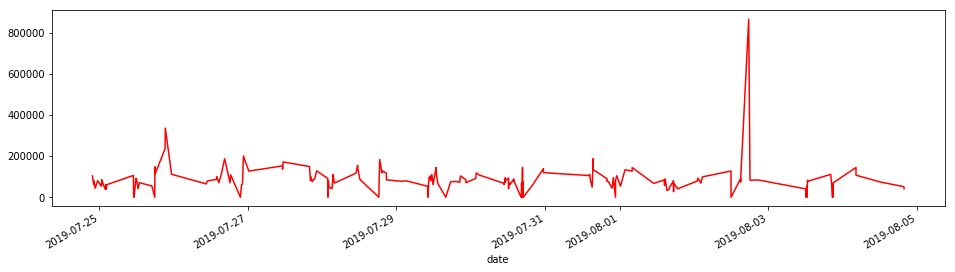

In [25]:
# # Visualzing data # #
# Time series
time_likes = pd.Series(data=df['likes'].values,index=df['date'])
time_likes.plot(figsize=(16,4),color='r')
plt.show()

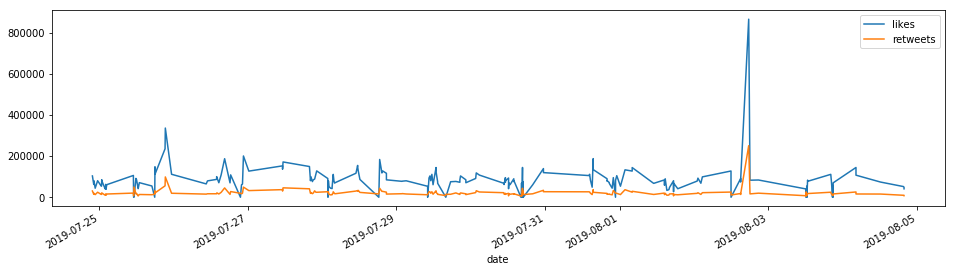

In [27]:
# Layered time series
time_likes = pd.Series(data=df['likes'].values,index=df['date'])
time_likes.plot(figsize=(16,4),label="likes",legend=True)

time_retweets = pd.Series(data=df['retweets'].values,index=df['date'])
time_retweets.plot(figsize=(16, 4), label="retweets", legend=True)

plt.show()

In [28]:
# # Sentiment analysis # #
df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
print(df.head(10))

                                              tweets                   id  \
0  ....The flags at the White House will be lower...  1158102732085108736   
1  Today, I authorized the lowering of the flags ...  1158102730696736768   
2  God bless the people of El Paso, Texas. God bl...  1158099851248377856   
3  The FBI, local and state law enforcement are w...  1157987941182033920   
4  ....Melania and I send our heartfelt thoughts ...  1157868519964499968   
5  Today’s shooting in El Paso, Texas, was not on...  1157868518823596032   
6  'God be with you all': Trump pledges full supp...  1157757443901972480   
7  RT @i24NEWS_EN: There is nothing racist about ...  1157755915283718145   
8  Pastor Scott, a great guy - and tough! https:/...  1157755353876107270   
9  RT @PastorDScott: Contrary to what the Left's ...  1157754118917828608   

   len                date              source   likes  retweets  sentiment  
0  140 2019-08-04 19:49:42  Twitter for iPhone   40947      7621          